In [1]:
%load_ext autoreload
%autoreload 2
import multiprocessing
multiprocessing.set_start_method("spawn")
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
import argparse
import numpy as np
import torch
import os
from collections import Counter
from tqdm.auto import tqdm
import sys
from datetime import datetime
import sys
import os
from utils import (
    same_recons, get_topk_acc, get_layer_names,
    evaluate_performance, Logger, prepare_encoders, get_layer_names_new
)
from intervention_utils import intervension
from Faithfulness.IterativePatching import initialize_model, prepare_inputs
import glob
def load_dataset(operation, base_path=None, eval="TRAIN"):
    if base_path is None:
        path = os.path.join("data", "Arco", "CircuitFinding")
    else:
        path = os.path.join(base_path, "data", "Arco", "CircuitFinding")
    abs_path = os.path.abspath(path)

    # print(f"{abs_path}/dataset_{operation}_*.npz")
    file_path = glob.glob(f"{abs_path}/dataset_{operation}_*.npz")[0]
    data = np.load(file_path, allow_pickle=True)
    # print("length dataset:", len(data))
    return data

In [3]:
import json
with open("../circuit_config_2.json", "r") as f:
    configs = json.load(f)

In [ ]:
intervention_class, model = initialize_model(base_path="..")
full_range = set(range(0, 117))  # 0 to 117 inclusive
EVAL = "TEST"


for config in configs[:]:
    if config["patch_type"] == "resample":
        continue
    OPERATION = config["operation"]
    PATCH_TYPE = config["patch_type"] # mean or resample
    CTR_TOKEN = config["CTR_token"]
    CIRCUIT = config["circuit"]
    CTR = config["CTR"]
   
    MAX_SAMPLES = 500

    print("\n\n-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-")
    print(f"Operation: {config['operation']}, {config['patch_type']}, {config['Evaluation_type']}, CL: {len(CIRCUIT)}")
    print("-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-")
    
    layer_names = get_layer_names_new()
    datapoints = load_dataset(OPERATION, base_path="..", eval=EVAL)["incorrect"]
    datapoints = np.array(datapoints, dtype=object)

    if PATCH_TYPE == "mean":
        mean_patches = np.load("../data/Arco/MeanPatching/mean_patching_10000.npy", allow_pickle=True).item()
    elif PATCH_TYPE == "resample":
        n = 100 if EVAL == "TRAIN" else 400 if OPERATION != "log" else 209
        data_name = f"../../data/Arco/ResamplePatching/cached_values_{n}_{OPERATION}_{CTR_TOKEN}_{EVAL}.npz"
        if CTR:
            print("Using CTR ONLY")
            mean_patches = np.load(data_name, allow_pickle=True)["resample_patch_CTR"]
        else:
            mean_patches = np.load(data_name, allow_pickle=True)["resample_patch_mean"]
    else:
        raise NotImplementedError

    if len(datapoints) == 0:
        continue

    def get_eqs(datapoints):
        d = []
        for data in datapoints:
            prefix = data["prefix"]
            eq = ["<S>"] + prefix[:prefix.index(OPERATION)]
            d.append((data, eq))
        return d
    datapoints = get_eqs(datapoints)
    
    Xs, ys, equations, eqs_untill_target = prepare_inputs(intervention_class, 
                                                          datapoints, 
                                                          200, 
                                                          max_samples=MAX_SAMPLES)
    patch_type = PATCH_TYPE
    Xs = np.array(Xs)
    ys = np.array(ys)
    Xs = torch.from_numpy(Xs).float()
    ys = torch.from_numpy(ys).float()
    equations = np.array(equations)
    eqs_untill_target = np.array(eqs_untill_target, dtype=object)
    
    # Baseline
    encoders = prepare_encoders(layer_names, [], mean_patches, patch_type, model, Xs, ys)
    ranks, counter, logit_score = evaluate_performance(model,
                                                         intervention_class,
                                                         encoders,
                                                         equations,
                                                         eqs_untill_target,
                                                         OPERATION,
                                                         return_activation=True)
    base_top1 = get_topk_acc(counter, 1)
    base_top2 = get_topk_acc(counter, 2)
    base_top3 = get_topk_acc(counter, 3)
    print(f"model:              Top-1: {base_top1:.3f}, Top-2: {base_top2:.3f}, Top-3: {base_top3:.3f}, logit score: {logit_score.mean():.3f}")
    
    idxs = [i for i, val in enumerate(ranks) if val >= 4]
    
    # performance of model with circuit only
    excluded = full_range - set(CIRCUIT)
    encoders = prepare_encoders(layer_names, excluded, mean_patches, patch_type, model, Xs[idxs], ys[idxs])
    ranks, counter, logit_score = evaluate_performance(model,
                                                intervention_class,
                                                encoders,
                                                equations[idxs],
                                                eqs_untill_target[idxs],
                                                OPERATION,
                                                return_activation=True)

    top1 = get_topk_acc(counter, 1)
    top2 = get_topk_acc(counter, 2)
    top3 = get_topk_acc(counter, 3)
    print(f"Circuit:            Top-1: {top1:.3f}, Top-2: {top2:.3f}, Top-3: {top3:.3f}, logit score: {logit_score.mean():.3f}")
    
    encoders = prepare_encoders(layer_names, full_range, mean_patches, patch_type, model, Xs, ys)
    ranks, counter, logit_score = evaluate_performance(model,
                                                         intervention_class,
                                                         encoders,
                                                         equations,
                                                         eqs_untill_target,
                                                         OPERATION,
                                                         return_activation=True)
    
    base_top1 = get_topk_acc(counter, 1)
    base_top2 = get_topk_acc(counter, 2)
    base_top3 = get_topk_acc(counter, 3)
    print(f"model compliment:   Top-1: {base_top1:.3f}, Top-2: {base_top2:.3f}, Top-3: {base_top3:.3f}, logit score: {logit_score.mean():.3f}")
    
    # performance of model with circuit only
    excluded = full_range - set(CIRCUIT)
    encoders = prepare_encoders(layer_names, CIRCUIT, mean_patches, patch_type, model, Xs, ys)
    ranks, counter, logit_score = evaluate_performance(model,
                                                intervention_class,
                                                encoders,
                                                equations,
                                                eqs_untill_target,
                                                OPERATION,
                                                return_activation=True)
    
    top1 = get_topk_acc(counter, 1)
    top2 = get_topk_acc(counter, 2)
    top3 = get_topk_acc(counter, 3)
    print(f"Circuit compliment: Top-1: {top1:.3f}, Top-2: {top2:.3f}, Top-3: {top3:.3f}, logit score: {logit_score.mean():.3f}")

Total entries: 1.1


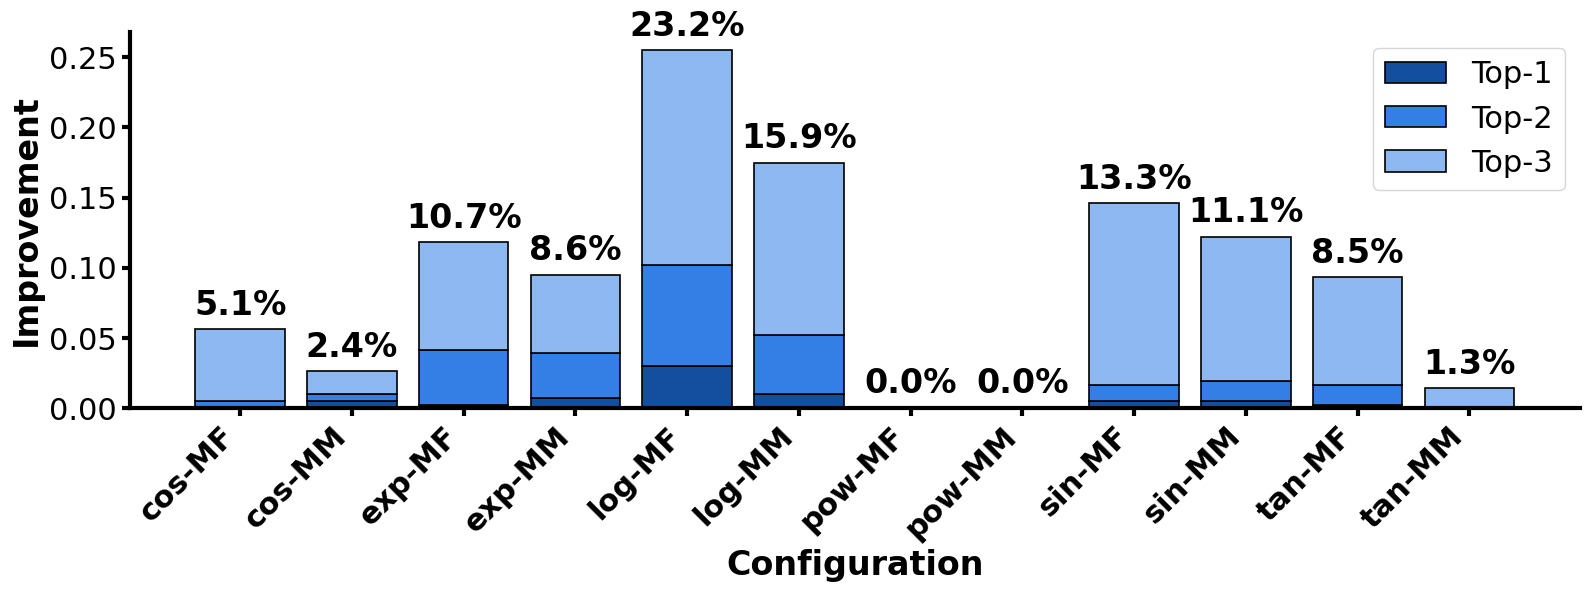

In [ ]:
from vis_utils import plot_frequency_stacked

names = []
heights = []

for config, values in results.items():
    names.append({config: ["Top-1", "Top-2", "Top-3"]})
    heights.append(values)

plot_frequency_stacked(
    names=names,
    heights=heights,
    title="",
    stacked_base_color=(0.2, 0.5, 0.9),  # adjust as desired (0.2, 0.5, 0.9)
    x_axis_name="Configuration",
    y_axis_name="Improvement",
    legend_include_percentage=False,
    save_fig=True,
    fig_size=(16,6),
    legend_padding=0,
    save_name="../pictures/circuitfinding/improvement_scores.pdf", adjust_x_ticks = True
)
